### Data Description

The dataset has 4 main columns

1. Time in seconds
2. Slurry rate (bpm, barrels per minute)
3. Proppant concentration (ppg, pounds per gallon)
4. Treating pressure (PSI)

### Objectives

Build an LSTM Model to use the last 60 seconds of slurry rate and proppant concentration data to predict treatment pressure for the next second, for example the first 60 seconds of data will be used to predict the next second (61st) and so on.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
## Time series data
tsdata = pd.read_excel('STP.xlsx')

In [3]:
data = tsdata.drop(['Time'], axis = 1)

In [4]:
data.head()

,SLUR RATE,PROP CON,TR PRESS
0,64.4,0.0,7913.0
1,64.8,0.0,8000.0
2,65.2,0.0,8049.0
3,65.7,0.0,8081.0
4,66.4,0.0,8132.0


In [5]:
data.describe()

,SLUR RATE,PROP CON,TR PRESS
count,4752.000000,4752.000000,4588.000000
mean,99.710795,1.422033,8142.469922
std,3.308136,0.703032,85.671249
min,64.400000,0.000000,7913.000000
25%,99.900000,1.000000,8088.000000
50%,100.300000,1.500000,8116.000000
75%,100.700000,2.000000,8193.000000
max,101.600000,3.500000,8708.000000


### Handling Missing Data

In [6]:
## Checking which column has missing values

missingdata_df = data.columns[data.isnull().any()].tolist()
missing_val_count_by_column = data.isnull().sum()

print(missing_val_count_by_column[missing_val_count_by_column>0])

TR PRESS    164
dtype: int64


In [7]:
data.columns

Index(['SLUR RATE', 'PROP CON', 'TR PRESS'], dtype='object')

In [8]:
## Standarizing the data

from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
scale.fit(data)
data_scaled = scale.transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=['SLUR RATE', 'PROP CON', 'TR PRESS'])

In [9]:
## Using KNN to impute missing values

from fancyimpute import KNN
X_filled = KNN(k=2).fit_transform(data_scaled)
X_filled = pd.DataFrame(X_filled, columns=data.columns)

Imputing row 1/4752 with 0 missing, elapsed time: 1.694
Imputing row 101/4752 with 0 missing, elapsed time: 1.694
Imputing row 201/4752 with 0 missing, elapsed time: 1.694
Imputing row 301/4752 with 0 missing, elapsed time: 1.696
Imputing row 401/4752 with 0 missing, elapsed time: 1.696
Imputing row 501/4752 with 0 missing, elapsed time: 1.696
Imputing row 601/4752 with 0 missing, elapsed time: 1.696
Imputing row 701/4752 with 0 missing, elapsed time: 1.696
Imputing row 801/4752 with 0 missing, elapsed time: 1.697
Imputing row 901/4752 with 0 missing, elapsed time: 1.697
Imputing row 1001/4752 with 0 missing, elapsed time: 1.697
Imputing row 1101/4752 with 0 missing, elapsed time: 1.697
Imputing row 1201/4752 with 0 missing, elapsed time: 1.697
Imputing row 1301/4752 with 0 missing, elapsed time: 1.698
Imputing row 1401/4752 with 0 missing, elapsed time: 1.698
Imputing row 1501/4752 with 0 missing, elapsed time: 1.698
Imputing row 1601/4752 with 0 missing, elapsed time: 1.698
Imputing 

In [10]:
## Returning the scaled data to the original data

X_filled = scale.inverse_transform(X_filled)
X_filled = pd.DataFrame(X_filled, columns = data.columns)

In [11]:
## Saving the processed data (no missing values)

X_filled.to_csv('STP_Processed.csv', index = False)

In [12]:
## Importing the processed data

data = pd.read_csv('STP_Processed.csv')
data['Time'] = tsdata['Time']
data = data[['Time', 'SLUR RATE', 'PROP CON', 'TR PRESS']]

In [13]:
data.head()

,Time,SLUR RATE,PROP CON,TR PRESS
0,1,64.4,0.0,7913.0
1,2,64.8,0.0,8000.0
2,3,65.2,0.0,8049.0
3,4,65.7,0.0,8081.0
4,5,66.4,0.0,8132.0


### Plotting and Understanding

Text(0, 0.5, 'Slurry Rate (bpm)')

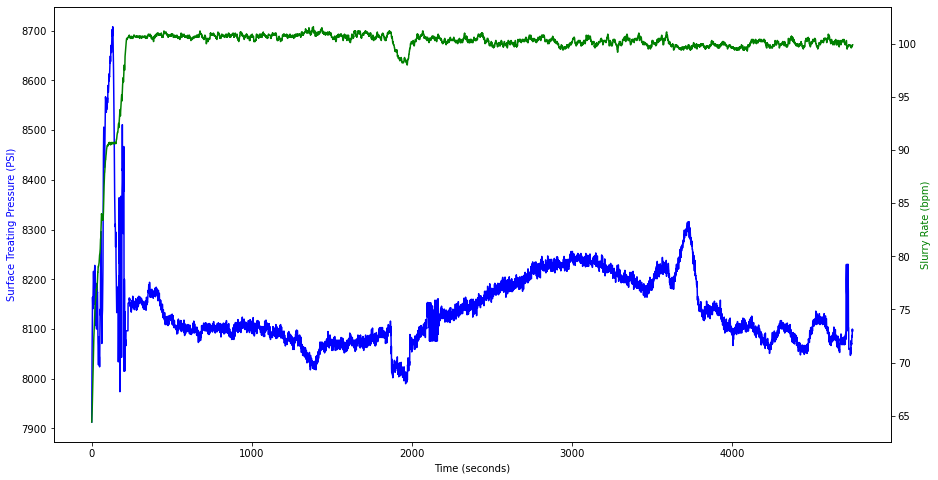

<Figure size 1080x576 with 0 Axes>

In [14]:
## Plotting the surface treating pressure and slurry rate

_, ax1 = plt.subplots(figsize = (15, 8))
plt.figure(figsize = (15, 8))
ax2 = ax1.twinx()

ax1.plot(data['Time'], data['TR PRESS'], 'b')
ax2.plot(data['Time'], data['SLUR RATE'], 'g')
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Surface Treating Pressure (PSI)', color = 'b')
ax2.set_ylabel('Slurry Rate (bpm)', color = 'g')

### Creating the Training and Test data splits

In [15]:
'''
Creating the training and test splits:
    First 4500s for Training
    Second 252s for Testing
'''

## Creating the training split

start_time = 1
end_time = 4500

filter = (data['Time'] > start_time) & (data['Time'] <= end_time)
data_training = data.loc[filter].copy()


## Creating the test split

start_time2 = 4500
end_time2 = 4752

filter = (data['Time'] > start_time2) & (data['Time'] <= end_time2)
data_testing = data.loc[filter].copy()

In [16]:
training_data = data_training.drop(['Time'], axis = 1)


past_60_secs = data_training.tail(60)
X_test_unscaled = past_60_secs.append(data_testing, ignore_index = True)
X_test_unscaled = X_test_unscaled.drop(['Time'], axis = 1)


scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
testing_data = scaler.transform(X_test_unscaled)

In [17]:
def train_data(window_size, data):
    '''
    This function takes the window size and that data(without time component)
    
    Returns the X_train and y_train
    '''
    
    X_train, y_train = [], []
    
    for i in range(window_size, data.shape[0]):
        X_train.append(data[i-window_size:i])
        y_train.append(data[i, 0])
    
    return np.array(X_train), np.array(y_train)


def test_data(window_size, data):
    X_test, y_test = [], []
    
    for i in range(window_size, data.shape[0]):
        X_test.append(data[i-window_size:i])
        y_test.append(data[i, 0])
    
    return np.array(X_test), np.array(y_test)

In [98]:
## Training and test datasets with 30s window size
X_train_30s, y_train_30s = train_data(30, training_data)
X_test_30s, y_test_30s = train_data(30, testing_data)


## Training and test datasets with 60s window size
X_train_60s, y_train_60s = train_data(60, training_data)
X_test_60s, y_test_60s = train_data(60, testing_data)


## Training and test datasets with 90s window size
X_train_90s, y_train_90s = train_data(90, training_data)
X_test_90s, y_test_90s = train_data(90, testing_data)

In [ ]:
print(X_train_30s.shape, y_train_30s.shape)

print(X_train_60s.shape, y_train_60s.shape)

print(X_train_90s.shape, y_train_90s.shape)

### LSTM Model

In [20]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow as tf
import random as python_random

In [21]:
def reset_seeds():
    np.random.seed(100)
    python_random.seed(100)
    tf.random.set_seed(100)
reset_seeds()

In [23]:
Frac_LSTM = Sequential()
Frac_LSTM.add(LSTM(units = 200, activation = 'relu', return_sequences = True, input_shape = (X_train_30s.shape[1], 3)))
Frac_LSTM.add(Dropout(0.3))
Frac_LSTM.add(LSTM(units = 200, activation = 'relu', return_sequences = True))
Frac_LSTM.add(Dropout(0.3))
Frac_LSTM.add(LSTM(units = 200, activation = 'relu'))
Frac_LSTM.add(Dropout(0.3))
Frac_LSTM.add(Dense(units=1))

Frac_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 200)           163200    
_________________________________________________________________
dropout (Dropout)            (None, 30, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                

In [24]:
Frac_LSTM.compile(optimizer='adam', loss='mean_squared_error')

In [25]:
history_30s = Frac_LSTM.fit(X_train_30s, y_train_30s, epochs = 100, batch_size = 32, shuffle = True)

Epoch 1/100
140/140 [==============================] - 10s 52ms/step - loss: 0.0351
Epoch 2/100
140/140 [==============================] - 7s 52ms/step - loss: 0.0066
Epoch 3/100
140/140 [==============================] - 8s 57ms/step - loss: 0.0058
Epoch 4/100
140/140 [==============================] - 8s 58ms/step - loss: 0.0053
Epoch 5/100
140/140 [==============================] - 8s 58ms/step - loss: 0.0050
Epoch 6/100
140/140 [==============================] - 9s 61ms/step - loss: 0.0050
Epoch 7/100
140/140 [==============================] - 9s 65ms/step - loss: 0.0049
Epoch 8/100
140/140 [==============================] - 8s 58ms/step - loss: 0.0045
Epoch 9/100
140/140 [==============================] - 8s 58ms/step - loss: 0.0040
Epoch 10/100
140/140 [==============================] - 8s 57ms/step - loss: 0.0041
Epoch 11/100
140/140 [==============================] - 8s 58ms/step - loss: 0.0038
Epoch 12/100
140/140 [==============================] - 8s 59ms/step - loss: 0.0041:

140/140 [==============================] - 9s 63ms/step - loss: 1.0644e-04
Epoch 96/100
140/140 [==============================] - 9s 62ms/step - loss: 1.1567e-04
Epoch 97/100
140/140 [==============================] - 9s 62ms/step - loss: 1.5482e-04
Epoch 98/100
140/140 [==============================] - 9s 62ms/step - loss: 9.8465e-05
Epoch 99/100
140/140 [==============================] - 9s 62ms/step - loss: 1.2212e-04
Epoch 100/100
140/140 [==============================] - 9s 61ms/step - loss: 1.2251e-04


In [26]:
Frac_LSTM_60s = Sequential()
Frac_LSTM_60s.add(LSTM(units = 200, activation = 'relu', return_sequences = True, input_shape = (X_train_60s.shape[1], 3)))
Frac_LSTM_60s.add(Dropout(0.3))
Frac_LSTM_60s.add(LSTM(units = 200, activation = 'relu', return_sequences = True))
Frac_LSTM_60s.add(Dropout(0.3))
Frac_LSTM_60s.add(LSTM(units = 200, activation = 'relu'))
Frac_LSTM_60s.add(Dropout(0.3))
Frac_LSTM_60s.add(Dense(units=1))

Frac_LSTM_60s.compile(optimizer='adam', loss='mean_squared_error')

In [29]:
history_60s = Frac_LSTM_60s.fit(X_train_60s, y_train_60s, epochs = 100, batch_size = 32, shuffle = True)

Epoch 1/100
139/139 [==============================] - 19s 120ms/step - loss: 0.1512
Epoch 2/100
139/139 [==============================] - 19s 138ms/step - loss: 0.0076
Epoch 3/100
139/139 [==============================] - 20s 142ms/step - loss: 0.0064
Epoch 4/100
139/139 [==============================] - 20s 143ms/step - loss: 0.0058
Epoch 5/100
139/139 [==============================] - 20s 144ms/step - loss: 0.0050
Epoch 6/100
139/139 [==============================] - 20s 143ms/step - loss: 0.0048
Epoch 7/100
139/139 [==============================] - 20s 143ms/step - loss: 0.0048
Epoch 8/100
139/139 [==============================] - 20s 146ms/step - loss: 0.0044
Epoch 9/100
139/139 [==============================] - 20s 144ms/step - loss: 0.0042
Epoch 10/100
139/139 [==============================] - 20s 144ms/step - loss: 0.0039
Epoch 11/100
139/139 [==============================] - 20s 145ms/step - loss: 0.0037
Epoch 12/100
139/139 [==============================] - 21s 152

Epoch 94/100
139/139 [==============================] - 19s 139ms/step - loss: 1.3613e-04
Epoch 95/100
139/139 [==============================] - 20s 141ms/step - loss: 2.9807e-04
Epoch 96/100
139/139 [==============================] - 20s 141ms/step - loss: 1009.7729
Epoch 97/100
139/139 [==============================] - 20s 141ms/step - loss: 2.5508e-04
Epoch 98/100
139/139 [==============================] - 19s 140ms/step - loss: 2.4081e-04
Epoch 99/100
139/139 [==============================] - 20s 141ms/step - loss: 2.1313e-04
Epoch 100/100
139/139 [==============================] - 20s 140ms/step - loss: 1.7776e-04


In [33]:
Frac_LSTM_90s = Sequential()
Frac_LSTM_90s.add(LSTM(units = 200, activation = 'relu', return_sequences = True, input_shape = (X_train_90s.shape[1], 3)))
Frac_LSTM_90s.add(Dropout(0.3))
Frac_LSTM_90s.add(LSTM(units = 200, activation = 'relu', return_sequences = True))
Frac_LSTM_90s.add(Dropout(0.3))
Frac_LSTM_90s.add(LSTM(units = 200, activation = 'relu'))
Frac_LSTM_90s.add(Dropout(0.3))
Frac_LSTM_90s.add(Dense(units=1))

Frac_LSTM_90s.compile(optimizer='adam', loss='mean_squared_error')

In [34]:
history_90s = Frac_LSTM_90s.fit(X_train_90s, y_train_90s, epochs = 100, batch_size = 32, shuffle = True)

Epoch 1/100
138/138 [==============================] - 27s 175ms/step - loss: 0.0425
Epoch 2/100
138/138 [==============================] - 27s 193ms/step - loss: 0.0059
Epoch 3/100
138/138 [==============================] - 30s 219ms/step - loss: 0.0054
Epoch 4/100
138/138 [==============================] - 30s 220ms/step - loss: 0.0049
Epoch 5/100
138/138 [==============================] - 31s 221ms/step - loss: 0.0051
Epoch 6/100
138/138 [==============================] - 30s 221ms/step - loss: 0.0044
Epoch 7/100
138/138 [==============================] - 31s 221ms/step - loss: 0.0044
Epoch 8/100
138/138 [==============================] - 31s 222ms/step - loss: 0.1387
Epoch 9/100
138/138 [==============================] - 31s 222ms/step - loss: 0.0052
Epoch 10/100
138/138 [==============================] - 31s 225ms/step - loss: 0.0045
Epoch 11/100
138/138 [==============================] - 31s 222ms/step - loss: 0.0043
Epoch 12/100
138/138 [==============================] - 31s 225

138/138 [==============================] - 31s 227ms/step - loss: 8.5637e-05
Epoch 94/100
138/138 [==============================] - 31s 226ms/step - loss: 9.4933e-05
Epoch 95/100
138/138 [==============================] - 31s 227ms/step - loss: 7.8808e-05
Epoch 96/100
138/138 [==============================] - 31s 226ms/step - loss: 4.6580e-04
Epoch 97/100
138/138 [==============================] - 32s 229ms/step - loss: 2.6629e-04
Epoch 98/100
138/138 [==============================] - 31s 225ms/step - loss: 1.7347e-04
Epoch 99/100
138/138 [==============================] - 31s 227ms/step - loss: 1.2851e-04
Epoch 100/100
138/138 [==============================] - 31s 227ms/step - loss: 1.0057e-04


### Key findings

In [100]:
## Finding the predicted value using each model

y_pred_30s = pd.DataFrame(Frac_LSTM.predict(X_test_30s), columns=['Predicted TR Press'])
y_pred_60s = pd.DataFrame(Frac_LSTM_60s.predict(X_test_60s), columns=['Predicted TR Press'])
y_pred_90s = pd.DataFrame(Frac_LSTM_90s.predict(X_test_90s), columns=['Predicted TR Press'])


## Transforming the y_test into dataframe to match the prediction shape
y_test_30s = pd.DataFrame(y_test_30s, columns=['Actual TR Press'])
y_test_60s = pd.DataFrame(y_test_60s, columns=['Actual TR Press'])
y_test_90s = pd.DataFrame(y_test_90s, columns=['Actual TR Press'])


In [101]:
## Inverse transforming the predictions and acutal 

y_pred_30s['Predicted TR Press'] = y_pred_30s['Predicted TR Press']*(data['TR PRESS'].max()-data['TR PRESS'].min())+(data['TR PRESS'].min())
y_pred_60s['Predicted TR Press'] = y_pred_60s['Predicted TR Press']*(data['TR PRESS'].max()-data['TR PRESS'].min())+(data['TR PRESS'].min())
y_pred_90s['Predicted TR Press'] = y_pred_90s['Predicted TR Press']*(data['TR PRESS'].max()-data['TR PRESS'].min())+(data['TR PRESS'].min())

y_test_30s['Actual TR Press'] = y_test_30s['Actual TR Press']*(data['TR PRESS'].max()-data['TR PRESS'].min())+(data['TR PRESS'].min())
y_test_60s['Actual TR Press'] = y_test_60s['Actual TR Press']*(data['TR PRESS'].max()-data['TR PRESS'].min())+(data['TR PRESS'].min())
y_test_90s['Actual TR Press'] = y_test_90s['Actual TR Press']*(data['TR PRESS'].max()-data['TR PRESS'].min())+(data['TR PRESS'].min())

In [116]:
from sklearn.metrics import mean_absolute_error

In [126]:
## Calculating the Mean Absolute Error

MEA_30s = mean_absolute_error(y_pred_30s, y_test_30s)
MEA_60s = mean_absolute_error(y_pred_60s, y_test_60s)
MEA_90s = mean_absolute_error(y_pred_90s, y_test_90s)

In [127]:
print(f"Mean Absolute Error for Window size of 30s = {MEA_30s}")
print(f"Mean Absolute Error for Window size of 60s = {MEA_60s}")
print(f"Mean Absolute Error for Window size of 90s = {MEA_90s}")

Mean Absolute Error for Window size of 30s = 7.853101421571519
Mean Absolute Error for Window size of 60s = 5.965622169384121
Mean Absolute Error for Window size of 90s = 5.922577681281788


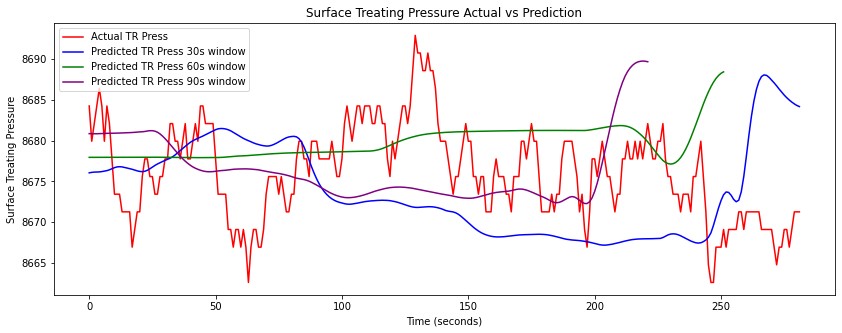

In [128]:
plt.figure(figsize = (14, 5))
plt.plot(y_test_30s, color = 'red', label = 'Actual TR Press')
plt.plot(y_pred_30s['Predicted TR Press'], color = 'blue', label = 'Predicted TR Press 30s window')
plt.plot(y_pred_60s['Predicted TR Press'], color = 'green', label = 'Predicted TR Press 60s window')
plt.plot(y_pred_90s['Predicted TR Press'], color = 'purple', label = 'Predicted TR Press 90s window')
plt.title('Surface Treating Pressure Actual vs Prediction')
plt.xlabel('Time (seconds)')
plt.ylabel('Surface Treating Pressure')
plt.legend()

#### We can find that LSTM Model with 90s window performed the best achieving a Mean Absolute Error of 5.923 PSI

### Plans and Next Steps

The next step is to include more data and predict the frac treating pressure minutes into the future.